## Simulation results for kA-model

In [1]:
import simpy 
import numpy as np
from heapq import *
import pandas as pd
import datetime
from datetime import timedelta
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
import warnings
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from simulation_functions import *

In [2]:
THETA = 10*40

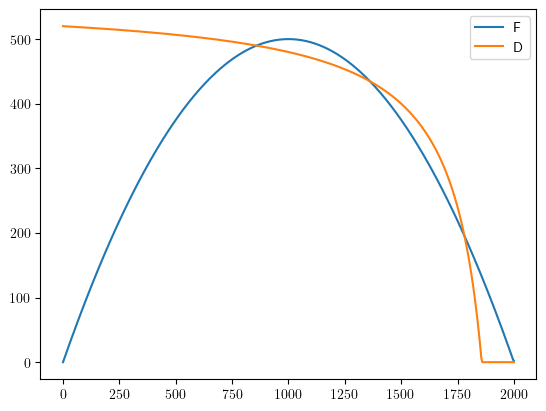

In [3]:
ks = np.linspace(0,kj,500)
plt.plot(ks,f(ks), label = 'F')
plt.plot(ks,D(μ(ks)), label = 'D')
plt.legend()

In [4]:
def get_A(A0, k0, delta_t):
    A = D(μ(k0)) - (D(μ(k0)) - A0)*np.exp(-THETA*delta_t/ω)
    return A

In [10]:
class Simulation():
    def __init__(self, start_density, start_inflow):
        self.li = [] 
        heapify(self.li)
        self.record= []
        self.cumm_curve = []
        self.travel = 0
        self.start_density = start_density
        self.start_inflow = start_inflow
        self.A0 = start_inflow
        self.t0 = 0
        self.k0 = start_density
        self.env = simpy.Environment()
        self.env.process(self.arrivals(self.env,self.li))
        self.traffic = self.env.process(self.traffic(self.env,self.li))
        self.env.run(until=100)
    
    def get_record(self):
        df = pd.DataFrame(np.array(self.record),columns=('t','n','q','v','D','A','Dinv','record type'))
        df['Dinv'] = df['Dinv'].astype(float)
        return df

    def get_cumm_curve(self):
        df = pd.DataFrame(np.array(self.cumm_curve), columns=('t','n','u', 'type'))
        return df
        
        
    def arrivals(self, env,li):
        #initialize
        for i in range(self.k0):
            heappush(li,rnd_dev())
            
        while True:
            d = D(μ(len(li)))#the demand rate
            n = len(li)
            v = V(len(li))
            A = get_A(self.A0, self.k0, env.now - self.t0)
            if A==0:
                yield env.timeout(0.05)
            else:
                yield env.timeout(rng.exponential(1/A))
                self.record.append([env.now,n,v*n,v,d,A,Dinv(A),1])
                self.cumm_curve.append([env.now, n, μ(n),1])
                heappush(li,self.travel+rnd_dev())
                self.A0 = get_A(self.A0, self.k0, env.now - self.t0)
                self.t0 = env.now
                self.k0 = len(li)
                # print(env.now)
                self.traffic.interrupt()
                

    def traffic(self,env,li):   
        while True:
            if li:
                tr = nsmallest(1,li)[0]
                n = len(li)
                v = V(n)
                A = 0
                self.record.append([env.now,n,v*n,v,D(μ(len(li))),A,Dinv(A),0])
                δ = (tr-self.travel)/v
                now = env.now
                try:
                    yield env.timeout(δ)
                    self.travel = heappop(li)
                    self.cumm_curve.append([env.now, n, μ(n),0])
                    self.A0 = get_A(self.A0, self.k0, env.now - self.t0)
                    self.t0 = env.now
                    self.k0 = len(li)
                except:
                    self.travel = self.travel + (env.now - now)*V(len(li))
                    self.A0 = get_A(self.A0, self.k0, env.now - self.t0)
                    self.t0 = env.now
                    self.k0 = len(li)
                    # print("interrupted!!!!")
                

In [19]:
sim1 = Simulation(1900, 100)
sim2 = Simulation(1600, 300)
sim3 = Simulation(1300, 400)
sim4 = Simulation(10, 300)

Exception ignored in: <generator object Simulation.traffic at 0x7f5268d5bbc0>
Traceback (most recent call last):
  File "/home/ayush/miniconda3/envs/econ/lib/python3.10/site-packages/numpy/lib/function_base.py", line 2361, in _get_ufunc_and_otypes
    if builtins.any(arg.size == 0 for arg in args):
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Simulation.traffic at 0x7f52515ca1f0>
Traceback (most recent call last):
  File "/home/ayush/miniconda3/envs/econ/lib/python3.10/site-packages/numpy/lib/function_base.py", line 2360, in _get_ufunc_and_otypes
    args = [asarray(arg) for arg in args]
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Simulation.traffic at 0x7f526820bbc0>
Traceback (most recent call last):
  File "/home/ayush/miniconda3/envs/econ/lib/python3.10/site-packages/numpy/lib/function_base.py", line 2360, in _get_ufunc_and_otypes
    args = [asarray(arg) for arg in args]
RuntimeError: generator igno

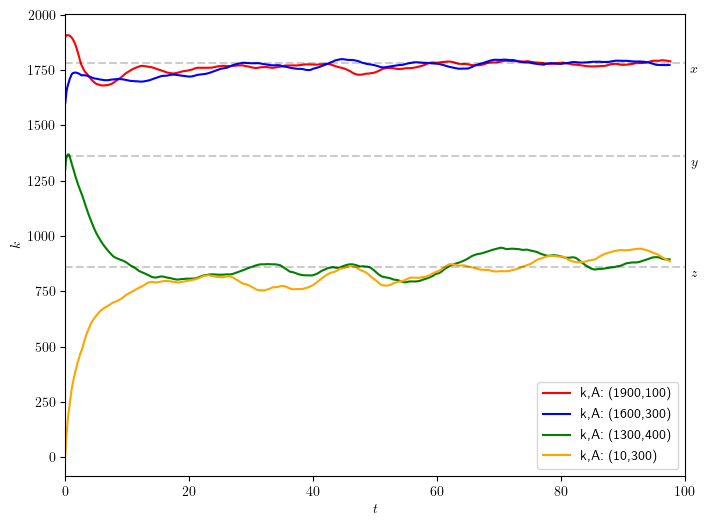

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_Tn_curve([sim1, sim2, sim3, sim4], 'kA', save = "../../fig/kA_model/sim/logn_Tn.pdf")

In [9]:

def add_arrow_to_line2D(
    axes, line, arrow_locs=[0.5],
    arrowstyle='-|>', arrowsize=1, transform=None):
    """
    Add arrows to a matplotlib.lines.Line2D at selected locations.

    Parameters:
    -----------
    axes: 
    line: Line2D object as returned by plot command
    arrow_locs: list of locations where to insert arrows, % of total length
    arrowstyle: style of the arrow
    arrowsize: size of the arrow
    transform: a matplotlib transform instance, default to data coordinates

    Returns:
    --------
    arrows: list of arrows
    """
    if not isinstance(line, mlines.Line2D):
        raise ValueError("expected a matplotlib.lines.Line2D object")
    x, y = line.get_xdata(), line.get_ydata()

    arrow_kw = {
        "arrowstyle": arrowstyle,
        "mutation_scale": 10 * arrowsize,
    }

    color = line.get_color()
    use_multicolor_lines = isinstance(color, np.ndarray)
    if use_multicolor_lines:
        raise NotImplementedError("multicolor lines not supported")
    else:
        arrow_kw['color'] = color

    linewidth = line.get_linewidth()
    if isinstance(linewidth, np.ndarray):
        raise NotImplementedError("multiwidth lines not supported")
    else:
        arrow_kw['linewidth'] = linewidth

    if transform is None:
        transform = axes.transData

    arrows = []
    for loc in arrow_locs:
        s = np.cumsum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))
        n = np.searchsorted(s, s[-1] * loc)
        arrow_tail = (x[n], y[n])
        arrow_head = (np.mean(x[n:n + 2]), np.mean(y[n:n + 2]))
        p = mpatches.FancyArrowPatch(
            arrow_tail, arrow_head, transform=transform,
            **arrow_kw)
        axes.add_patch(p)
        arrows.append(p)
    return arrows

In [10]:
def get_At_plot(n_steps, A0, k0, save = None):
    t = rng.exponential(1, n_steps)
    cumm_t = [sum(t[0:i]) for i in range(n_steps+1)]
    delta_k = rng.choice([-1, 1], n_steps)
    A0 = A0
    k0 = k0
    Aarr = np.array([A0])
    tarr = np.array([0])
    A = lambda k, A0, t: D(μ(k)) - (D(μ(k)) - A0)*np.exp(-THETA*t/ω)
    fig, ax = plt.subplots()
    for (i,ti)  in enumerate(t):
        tadd = np.linspace(tarr[-1], tarr[-1]+ti, 100)
        tin = np.linspace(0, ti, 100)
        Aadd = A(k0, Aarr[-1], tin)
        k0 = k0 + delta_k[i]
        Aarr = np.append(Aarr, Aadd)
        tarr = np.append(tarr, tadd)
        line, = ax.plot(tadd, Aadd, ls = "--", color = 'blue')
        if delta_k[i] == 1:
            ax.vlines(tadd[-1], ymin = 291, ymax = 295, alpha = 0.2, ls = '-.', color = 'green', label = "Entry")
        if delta_k[i] == -1:
            ax.vlines(tadd[-1], ymin = 291, ymax = 295, alpha = 0.2, ls = '-.', color = 'red', label = "Exit")
        add_arrow_to_line2D(ax, line = line)
        ax.scatter(tadd[-1], Aadd[-1], color = 'k')
    # ax.plot(tarr, Aarr, ls = '--')
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.set(xlabel = r"$t$", ylabel = r"$A(t)$")
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    if save:
        fig.savefig(save)

In [11]:
def get_kt_plot(n_steps, A0, k0, save = None):
    t = rng.exponential(1, n_steps)
    cumm_t = [sum(t[0:i]) for i in range(n_steps+1)]
    delta_k = rng.choice([-1, 1], n_steps)
    A0 = A0
    k0 = k0
    Aarr = np.array([A0])
    tarr = np.array([0])
    A = lambda k, A0, t: D(μ(k)) - (D(μ(k)) - A0)*np.exp(-THETA*t/ω)
    fig, ax = plt.subplots()
    for (i,ti)  in enumerate(t):
        tadd = np.linspace(tarr[-1], tarr[-1]+ti, 100)
        tin = np.linspace(0, ti, 100)
        Aadd = A(k0, Aarr[-1], tin)
        kadd = k0*np.ones_like(tadd)
        ax.plot(tadd, kadd, ls = "--", color = 'blue')
        k0 = k0 + delta_k[i]
        Aarr = np.append(Aarr, Aadd)
        tarr = np.append(tarr, tadd)
        if delta_k[i] == 1:
            plt.axvline(tadd[-1], alpha = 0.2, ls = '-.', color = 'green', label = "Arrival")
        if delta_k[i] == -1:
            plt.axvline(tadd[-1], alpha = 0.2, ls = '-.', color = 'red', label = "Departure")
        # ax.scatter(tadd[-1], Aadd[-1], color = 'k')
    # ax.plot(tarr, Aarr, ls = '--')
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.set(xlabel = r"$t$", ylabel = r"$k(t)$")
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    if save:
        fig.savefig(save)

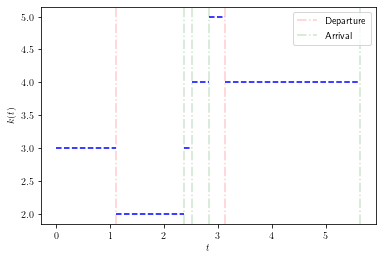

In [12]:
get_kt_plot(6, 100, 3, "../../fig/kA_model/sim.kt.pdf")

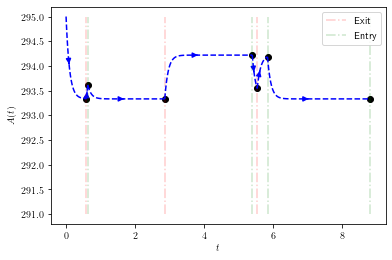

In [13]:
# get_At_plot(7, 295, 1700, save = "../../fig/kA_model/sim/At.pdf")
get_At_plot(7, 295, 1700)